# Lab 3 - Query Expansion

In [1]:
import os
import sys
sys.path.append('../..')
import chromadb
import umap.umap_ as umap

from helper_utils_02 import load_pdf_chroma, word_wrap, project_embeddings,flatten
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
from py3810.myUtils import pickle_dump, pickle_load

In [2]:
# Specify the directory to store the database files
path_chromadb_dump = '../Chromadb/'
persist_dir = '../Chromadb/collections/'
is_persistent = True

filename_pdf = 'microsoft_annual_report_2022.pdf'
collection_name = 'microsoft_annual_report_2022'
embedding_function = SentenceTransformerEmbeddingFunction()

In [3]:
if is_persistent:
  try:
    client = chromadb.PersistentClient(path=persist_dir)
    chroma_collection = client.get_collection(name=collection_name, embedding_function=embedding_function)
    embeddings = pickle_load(filename_pickle='_embeddings', path_pickle_dump=path_chromadb_dump)
    umap_transform = pickle_load(filename_pickle='_umap_transform', path_pickle_dump=path_chromadb_dump)
    projected_dataset_embeddings = pickle_load(filename_pickle='_projected_dataset_embeddings', path_pickle_dump=path_chromadb_dump)
    print(f'loaded embeddings, umpa_transform, projected_dataset_embeddings')
  except FileNotFoundError:
    chroma_collection = \
      load_pdf_chroma(
        filename_pdf=filename_pdf,
        collection_name=collection_name,
        embedding_function=embedding_function,
        persist_directory=persist_dir,
        is_persistent=is_persistent,
      )
    print(f'Created chroma_collection {collection_name}')
    print(f'chroma_collection.count(): {chroma_collection.count()}')
    embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
    umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
    projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)
    print(f'created embeddings, umpa_transform, projected_dataset_embeddings')
    pickle_dump(file_to_pickle=embeddings, filename_pickle='_embeddings', path_pickle_dump=path_chromadb_dump)
    pickle_dump(file_to_pickle=umap_transform, filename_pickle='_umap_transform', path_pickle_dump=path_chromadb_dump)
    pickle_dump(file_to_pickle=projected_dataset_embeddings, filename_pickle='_projected_dataset_embeddings', path_pickle_dump=path_chromadb_dump)    
    print(f'saved embeddings, umpa_transform, projected_dataset_embeddings')
else:
  if os.path.exists(persist_dir):
    client = chromadb.PersistentClient(path=persist_dir)
    chroma_collection = client.get_collection(name=collection_name, embedding_function=embedding_function)
    print(f'Loaded chroma_collection {collection_name}')
    embeddings = pickle_load(filename_pickle='_embeddings', path_pickle_dump=path_chromadb_dump)
    umap_transform = pickle_load(filename_pickle='_umap_transform', path_pickle_dump=path_chromadb_dump)
    projected_dataset_embeddings = pickle_load(filename_pickle='_projected_dataset_embeddings', path_pickle_dump=path_chromadb_dump)
    print(f'loaded embeddings, umpa_transform, projected_dataset_embeddings')
    print(f'chroma_collection.count(): {chroma_collection.count()}')
  else:
    chroma_collection = \
      load_pdf_chroma(
        filename_pdf=filename_pdf,
        collection_name=collection_name,
        embedding_function=embedding_function,
        persist_directory=persist_dir,
        is_persistent=True,  # Set True to save collection, can always delete directory
      )
    print(f'Created chroma_collection {collection_name}')
    print(f'chroma_collection.count(): {chroma_collection.count()}')
    embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
    umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
    projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)
    print(f'created embeddings, umpa_transform, projected_dataset_embeddings')
    pickle_dump(file_to_pickle=embeddings, filename_pickle='_embeddings', path_pickle_dump=path_chromadb_dump)
    pickle_dump(file_to_pickle=umap_transform, filename_pickle='_umap_transform', path_pickle_dump=path_chromadb_dump)
    pickle_dump(file_to_pickle=projected_dataset_embeddings, filename_pickle='_projected_dataset_embeddings', path_pickle_dump=path_chromadb_dump)    
    print(f'saved embeddings, umpa_transform, projected_dataset_embeddings')        

loaded embeddings, umpa_transform, projected_dataset_embeddings


#### Chroma Usage Guide
https://docs.trychroma.com/guides

In [4]:
import openai
from openai import OpenAI

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv('.env\my_api_key.env')) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

openai_client = OpenAI()

Don't run next cell if embeddings, umap_transform, projected_dataset_embeddings are loaded

## Expansion with generated answers

https://arxiv.org/abs/2305.03653

In [5]:
def augment_query_generated(query, model="gpt-3.5-turbo"):
  messages = [
    {
        "role": "system",
        "content": "You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report."
    },
    {"role": "user", "content": query}
  ] 

  response = openai_client.chat.completions.create(
    model=model,
    messages=messages,
  )
  content = response.choices[0].message.content
  return content

In [6]:
original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query)

joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

Was there significant turnover in the executive team? In the fiscal
year 20XX, our executive team experienced minimal turnover. Only one
executive position saw a change during the year when our Chief
Financial Officer retired after 10 years of service. A new CFO was
appointed from within the company, ensuring a smooth transition and
continuity in leadership.


In [7]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
  print(word_wrap(doc))
  print('')

88 report of independent registered public accounting firm to the
stockholders and the board of directors of microsoft corporation
opinion on internal control over financial reporting we have audited
the internal control over financial reporting of microsoft corporation
and subsidiaries ( the “ company ” ) as of june 30, 2022, based on
criteria established in internal control — integrated framework ( 2013
) issued by the committee of sponsoring organizations of the treadway
commission ( coso ). in our opinion, the company maintained, in all
material respects, effective internal control over financial reporting
as of june 30, 2022, based on criteria establis hed in internal control
— integrated framework ( 2013 ) issued by coso. we have also audited,
in accordance with the standards of the public company accounting
oversight board ( united states ) ( pcaob ), the consolidated financial
statements as of and for the year ended june 30, 2022, of the company
and

84 report of independent re

In [28]:
emb_values = flatten(results['embeddings'])
vector_dim = len(results['embeddings'][0][0])
query_results = len(results['embeddings'][0])

print(f'Chroma collection chunks:    {chroma_collection.count()}')
print(f'number of query results:     {query_results}')
print(f'embedding vector dimension:  {vector_dim}')
print(f'min embedding vectors value: {min(emb_values)}')
print(f'max embedding vectors value: {max(emb_values)}')
print(f'embedding vector[0][0][:3]:  {results["embeddings"][0][0][:3]} ...')
print(f'document[0][0][:50]:         {results["documents"][0][0][:50]} ...')


Chroma collection chunks:    388
number of query results:     5
embedding vector dimension:  384
min embedding vectors value: -0.18480335175991058
max embedding vectors value: 0.161090686917305
embedding vector[0][0][:3]:  [-0.009797703474760056, -0.023183956742286682, -0.06225508078932762] ...
document[0][0][:50]:         88 report of independent registered public account ...


In [10]:
retrieved_embeddings = results['embeddings'][0]  # list of embedding vectors
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


(-4.600989580154419, 5.3661816120147705, 5.747508931159973, 12.849176955223083)

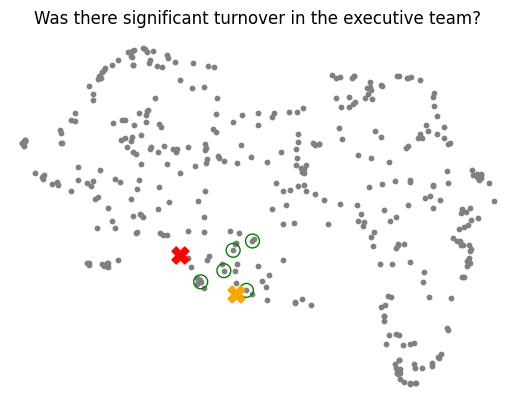

In [29]:
import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

## Expansion with multiple queries


In [30]:
def augment_multiple_query(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about an annual report. "
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [31]:
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

What were the key drivers behind the decrease in operating expenses?
Can you provide information on the company's net income for the past year?
What were the major challenges the company faced during the reporting period?
How did the company's revenue in the current year compare to the previous year?
Can you describe any significant changes in the company's market share?


#### Result of expansion with multiple queries return:  
- 6 queries, 5 embedding vectors and 5 docs for each query
- 6 queries are: results['embeddings'][0] ... results['embeddings'][5]
- 5 embedding vectors for query results['embeddings'][0] are: results['embeddings'][0][1] ... results['embeddings'][0][4]
- each embedding vector has dimension of 384, i.e. len(results['embeddings'][0][0])
- queries may return duplicates of embedding vectors and docs  

In [34]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
operating expenses increased $ 6. 3 billion or 14 % driven by
investments in cloud engineering, linkedin, gaming, and commercial
sales. key changes in operating expenses were : • research and
development expenses increased $ 3. 8 billion or 18 % driven by
investments in cloud engineering, gaming, and linkedin. • sales and
marketing expenses increased $ 1. 7 billion or 8 % driven by
investments in commercial sales and linkedin. sales and marketing
included a favorable foreign currency impact of 2 %. • general and
administrative expenses increased $ 793 million or 16 % driven by
investments in corporate functions. operating income increased $ 13. 5
billion or 19 % driven by growth across each of our segments. current
year net income and diluted eps were positively impacted by the net tax
benefit related to the transfer of intangible properties, which
resulted in an increase to net income and d

In [35]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)


100%|██████████| 5/5 [00:12<00:00,  2.46s/it]


In [36]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)


100%|██████████| 30/30 [01:12<00:00,  2.43s/it]


(-4.600989580154419, 5.3661816120147705, 5.747508931159973, 12.849176955223083)

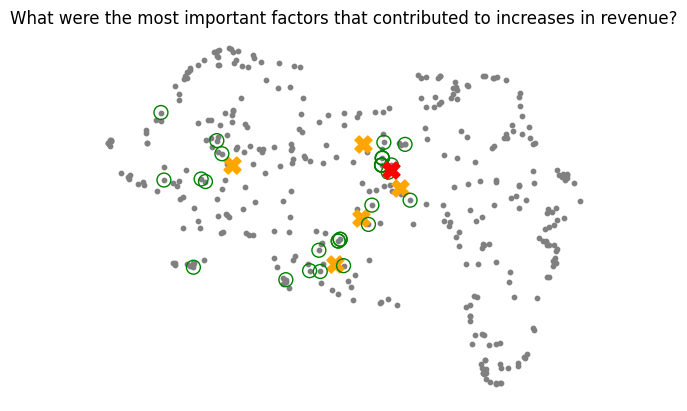

In [37]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')